# Temperature-dependence of 5-HT neuron population gain

In [1]:
from common import colors, pvalue_thresholds, savefig
from gain_util import (
    infer_gaba_condition,
    get_step_amplitudes,
    GainSimulationVisualizer,
    PSTHToGainIllustration
)

In [2]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..'))
print os.getcwd()

/home/efharkin/projects/raphegif/raphegif


In [3]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from scipy import stats
from tqdm.notebook import trange

from ezephys import pltools
from statannot import add_stat_annotation

from grr.Simulation import GIFnet_Simulation
from grr.Spiketrain import PSTH

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'publication_figure_style.dms'))
IMG_PATH = None

In [5]:
sim_dict = {
    'Circuit': [],
    'Mod type': [],
    'Condition': [],
    'Rep': [],
    'Model': [],
}

network_models = [
    '5HT_base',
    '5HT_heated_base',
]

DATA_PATH = os.path.join(os.getenv('DATA_PATH'), 'simulations', 'GIF_network', 'step_input')

for network_model in network_models:
    for gaba_condition in os.listdir(
        os.path.join(DATA_PATH, network_model)
    ):
        for fname in os.listdir(
            os.path.join(DATA_PATH, network_model, gaba_condition)
        ):
            if fname.endswith(('hdf5', 'h5')):

                sim_dict['Circuit'].append(
                    'DRN'
                )
                sim_dict['Mod type'].append(
                    re.search(r'5HT_(.*)', network_model).groups()[-1]
                )
                sim_dict['Condition'].append(
                    infer_gaba_condition(gaba_condition)
                )
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(
                            DATA_PATH,
                            network_model,
                            gaba_condition,
                            fname,
                        ),
                        mode='r',
                    )
                )

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Circuit,Condition,Mod type,Model,Rep
0,DRN,KO,base,[ser],0
1,DRN,KO,base,[ser],1
2,DRN,KO,base,[ser],2
3,DRN,KO,base,[ser],3
4,DRN,KO,base,[ser],4


In [6]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [7]:
PSTH_width = 50.

for i in trange(sim_df.shape[0]):
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] != 'KO':
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )
    else:
        sim_df.loc[i, 'GABA PSTH'] = None
        continue

print('\nDone!')

  0%|          | 0/40 [00:00<?, ?it/s]


Done!


In [8]:
psth_dict = {
    'Circuit': [],
    'Mod type': [],
    'Condition': [],
    'Principal PSTH': [],
    'GABA PSTH': [],
}
for circuit in sim_df['Circuit'].unique():
    for modtype in sim_df.loc[
        sim_df['Circuit'] == circuit, 'Mod type'
    ].unique():
        for cond in sim_df.loc[
            (sim_df['Circuit'] == circuit) & (sim_df['Mod type'] == modtype),
            'Condition',
        ].unique():
            psth_dict['Circuit'].append(circuit)
            psth_dict['Mod type'].append(modtype)
            psth_dict['Condition'].append(cond)
            psth_dict['Principal PSTH'].append(
                np.array(
                    sim_df.loc[
                        (sim_df['Circuit'] == circuit)
                        & (sim_df['Condition'] == cond)
                        & (sim_df['Mod type'] == modtype),
                        'Principal PSTH',
                    ].tolist()
                )
            )
            psth_dict['GABA PSTH'].append(
                np.array(
                    sim_df.loc[
                        (sim_df['Circuit'] == circuit)
                        & (sim_df['Condition'] == cond)
                        & (sim_df['Mod type'] == modtype),
                        'GABA PSTH',
                    ].tolist()
                )
            )
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [9]:
psth_df.head()

,Circuit,Condition,GABA PSTH,Mod type,Principal PSTH
0,DRN,KO,"[None, None, None, None, None, None, None, Non...",base,"[[[0.4000000059604645, 0.4000000059604645, 0.4..."
1,DRN,KO,"[None, None, None, None, None, None, None, Non...",heated_base,"[[[2.0666661262512207, 2.0666661262512207, 2.0..."


In [10]:
step_amplitudes = get_step_amplitudes(sim_df.loc[0, 'Model'], 1000.)

In [11]:
visualizer = GainSimulationVisualizer(psth_df, step_amplitudes, (800., 900.), (1000., 1900.))

In [12]:
# # Publication figures
# ## Interpretation of network output
gain_illustrator = PSTHToGainIllustration(
    visualizer, 
    marked_times=[1040., 1850.], 
    marker_fmt_strings=['ko', 'ks'], 
    marker_labels=['Early', 'Late'],
    markeredgecolor='white',
    markeredgewidth=0.3
)

Saving svg
Saving png
Done!


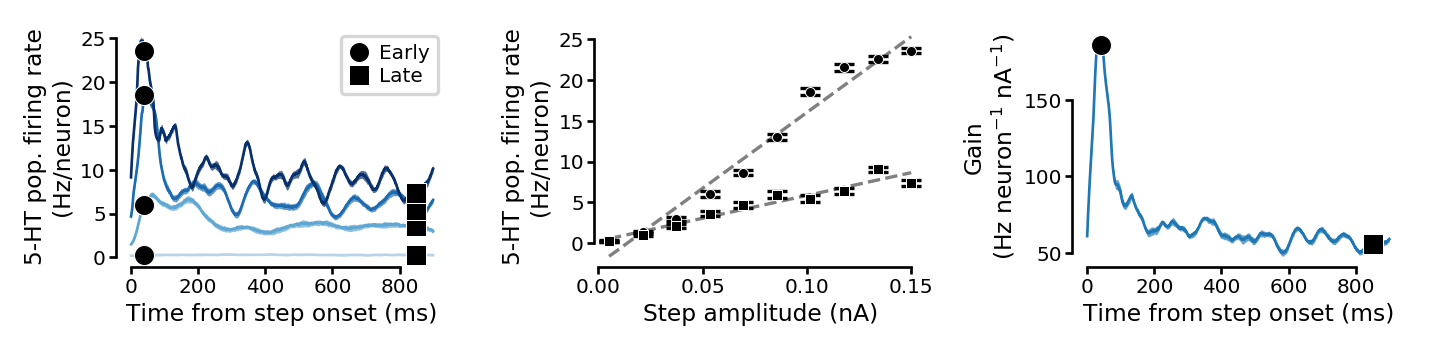

In [13]:
gain_illustrator.select_PSTH_dataset('DRN', 'KO', 'base', 'Principal PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Blues'), colors['ser'], '5-HT', 
    os.path.join(os.getenv('IMG_PATH'), 'control_gain_illustration')
)

Saving svg
Saving png
Done!


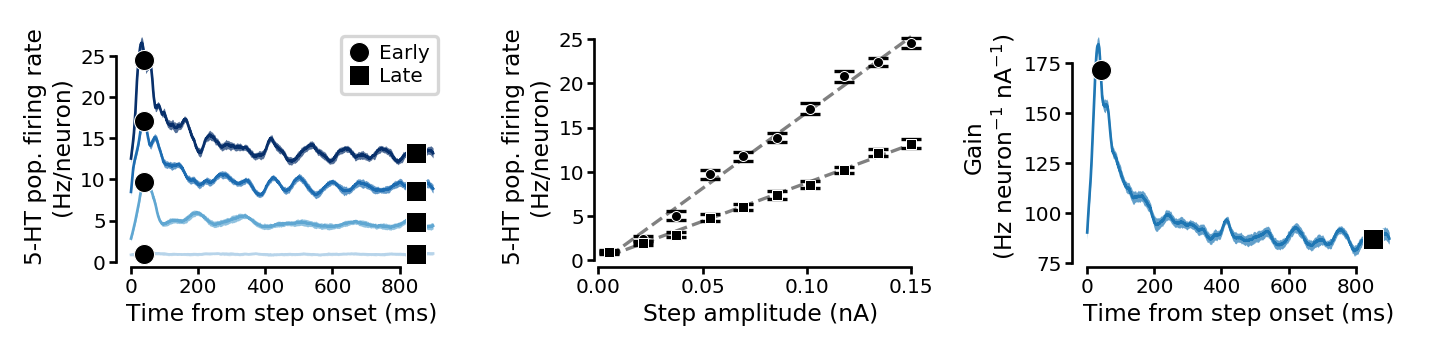

In [14]:
gain_illustrator.select_PSTH_dataset('DRN', 'KO', 'heated_base', 'Principal PSTH')
gain_illustrator.plot_PSTH_to_gain(
    plt.get_cmap('Blues'), colors['ser'], '5-HT', 
    os.path.join(os.getenv('IMG_PATH'), 'heated_control_gain_illustration')
)

## Effect of temperature

Saving svg
Saving png
Done!


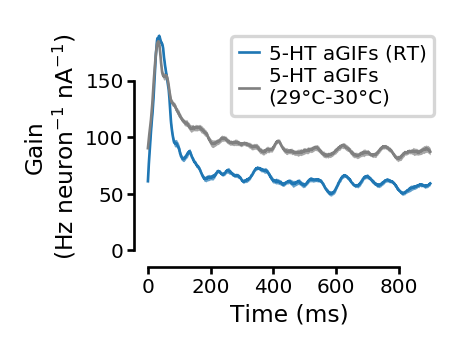

In [15]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'KO', 'base', 'Principal PSTH', color=colors['ser'], label='5-HT aGIFs (RT)')
visualizer.plot_gain('DRN', 'KO', 'heated_base', 'Principal PSTH', color='gray', label=u'5-HT aGIFs\n(29°C-30°C)')
plt.ylim(-15, plt.ylim()[1])
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

savefig(os.path.join(os.getenv('IMG_PATH'), 'time_dependent_gain_temp_comparison'))

In [16]:
def get_gain_peak(circuit, condition, mod_type, psth_type):
    gain = visualizer._fit_gain_estimator(circuit, condition, mod_type, psth_type).gainByRep
    return gain.max(axis=1)

def get_gain_ss(circuit, condition, mod_type, psth_type):
    gain = visualizer._fit_gain_estimator(circuit, condition, mod_type, psth_type).gainByRep
    return gain[:, -1000:].mean(axis=1)

def get_gain_ratio(circuit, condition, mod_type, psth_type):
    return get_gain_peak(circuit, condition, mod_type, psth_type) / get_gain_ss(circuit, condition, mod_type, psth_type)

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
o: 5.00e-02 < p <= 1.00e-01
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04
()
RT v.s. 29C-30C: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.302e-08 stat=2.927e+01
Saving svg
Saving png
Done!


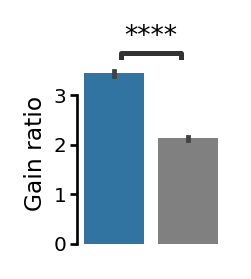

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(0.8, 1))

d = pd.DataFrame({
    'RT': get_gain_ratio('DRN', 'KO', 'base', 'Principal PSTH'),
    r'29C-30C': get_gain_ratio('DRN', 'KO', 'heated_base', 'Principal PSTH'),
}).melt()
sns.barplot(
    x='variable',
    y='value',
    data=d,
    order=['RT', '29C-30C'],
    palette=[colors['ser'], 'gray'],
    ci='sd',
    ax=axes
)
add_stat_annotation(
    ax=axes,
    plot='boxplot',
    x='variable',
    y='value',
    order=['RT', '29C-30C'],
    data=d,
    comparisons_correction='bonferroni',
    test='Kruskal',
    box_pairs=[('RT', '29C-30C')],
    pvalue_thresholds=pvalue_thresholds,
    loc='outside'
)
axes.set_ylabel('Gain ratio')
axes.set_xlabel('')
axes.set_xticks([])
pltools.hide_border('trb', trim=True)

savefig(os.path.join(os.getenv('IMG_PATH'), 'gain_ratio_temp_comparison'))
plt.show()

fig.clf()
plt.close(fig)

In [18]:
d.groupby('variable').mean()

,value
variable,
29C-30C,2.129720
RT,3.445162


In [19]:
d.groupby('variable').std()

,value
variable,
29C-30C,0.029007
RT,0.049846
